reference: 
- https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders
- https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders

다음을 토대로 autoencoder를 이용해 사기거래를 탐지하는 방법 2가지를 적용해보았다. 
- 기본 autoencoder의 방식처럼 인코더의 노드를 점차 감소하고 디코더를 통해 이를 다시 복구하는 과정에서 사기거래를 탐지하는 방법
- 인코더의 노드를 원래 column개수보다 많게 하여 차원을 증가시키고 이러한 잠재벡터를 이용해서 사기거래를 탐지하는 방법

### Content

1. [Dataset Preparation](#1)
2. [Visualize Fraud and NonFraud Transactions](#2) <br>
3. [Train/Validate/Test split](#3) <br>
4. [AutoEncoders](#4) <br>
4.1. [model1](#4.1) <br>
4.2. [model2](#4.2) <br>
5. [Fraud detection for model1](#5) <br>
5.1. [Reconstructions](#5.1) <br>
5.2. [Setting a threshold for classification](#5.2) <br>
6. [Fraud detection for model2](#6) <br>
6.1. [Obtain the Latent Representations](#6.1) <br>
6.2. [Visualize the latent representations : Fraud Vs Non Fraud
](#6.2) <br>
6.3. [Simple Linear Classifier](#6.3) <br>

<h1 align="center">Fraud Detection using Autoencoder</h1>

<a id="1"></a>
# 1. Dataset Preparation

In [3]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='whitegrid')
np.random.seed(203)

data = pd.read_csv('../../data/creditcard.csv')
data['Time'] = data['Time'].apply(lambda x: x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc['Class'].apply(lambda x: round(100*float(x)/len(data), 2))
vc = vc.rename(columns = {'index':'Target', 'Class':'Count'})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


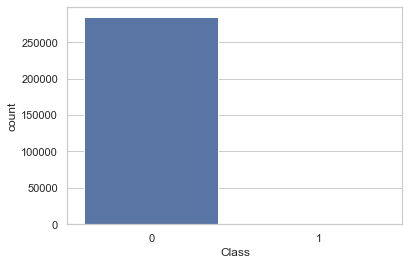

In [5]:
sns.countplot(x=data['Class'])
plt.show()

이 문제에서 가장 큰 어려운점은 사기거래가 오직 0.17%로 **taget이 매우 불균형하다는 점**이다. 하지만 representation learning의 장점은 그러한 불균형의 문제를 다룰 수 있다는 것이다. 

<br>

<a id="2"></a>
# 2. Visualize Fraud and NonFraud Transactions

### Consider only 1000 rows of non fraud cases

시각화를 위해 오직 정상 데이터의 1000건만을 고려해봅시다.

In [4]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

# frac=1을 설정해서 모든 데이터를 반환
# frac을 이용하면 전체 데이터의 shuffling이 가능
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis=1)
Y = df['Class']

In [5]:
print(f"""Shape of the datasets:
    non_fraud (rows, cols) = {non_fraud.shape}
    fraud     (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    non_fraud (rows, cols) = (1000, 31)
    fraud     (rows, cols) = (492, 31)


사기와 정상 거래를 T-sne를 사용해서 시각화해보자. T-SNE는 데이터의 차원을 줄여주는 데이터 분해 기법이고 가장 큰 정보들만 가지고 있는 상위 component만을 만들어준다. 

다음의 점들은 하나의 거래를 표현한다. 정상 거래는 green으로 사기 거래는 red로 표현되어있다. 두개의 축은 t-sne에 의해 추출된 component이다. 

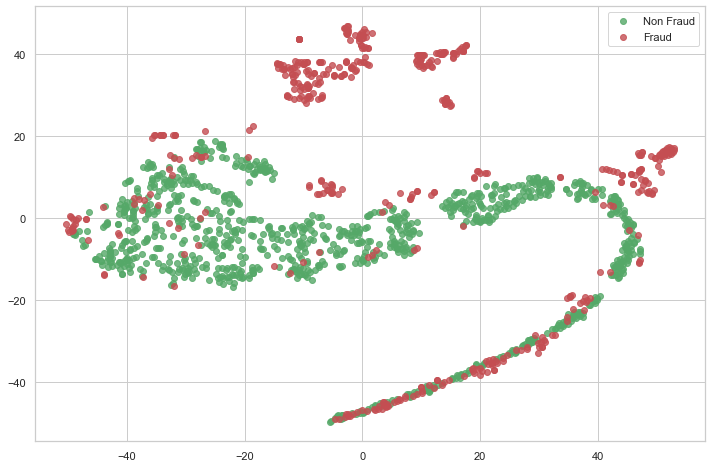

In [6]:
def tsne_plot(x1, y1, name='graph.png'):
    tsne = TSNE(n_components = 2, random_state = 0)
    X_t = tsne.fit_transform(x1)
    
    plt.figure(figsize=(12,8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
    
    plt.legend(loc='best'); 
    # plt.savefig(name)
    plt.show()
    
tsne_plot(X, Y, 'original.png')

위의 시각화를 보면 많은 정상 거래와 사기 거래가 가깝게 위치해 있는 것을 볼 수 있다. 즉 모델을 통해 정확하게 분류하기가 어렵다고 판단된다. 

<br>

<a id="3"></a>
# 3. Train/Validate/Test split

In [6]:
# parameters
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# training set: 오직 정상거래만을 이용해서 학습시킨다.
X_train = non_fraud.iloc[:TRAINING_SAMPLE].drop('Class', axis=1)

# 학습 데이터 중에서도 0.2% () 비율로 검증용 데이터를 만든다. 
X_train, X_validate = train_test_split(X_train, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)

# testing  set: 예측에 대해 성능을 평가하기 위해 나머지 정상 거래와 사기 거래를 합해서 테스트 셋을 만든다. 
X_test = non_fraud.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)
X_test, y_test = X_test.drop('Class', axis=1).values, X_test.Class

In [7]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    testing  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 30)
    validate (rows, cols) = (40000, 30)
    testing  (rows, cols) = (84807, 30)


### pipeline을 통해서 학습, 검증용 데이터를 정규화

In [8]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# pipeline 설정
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

<br>

<a id="4"></a>
# 4. AutoEncoders 

autoencoder가 무엇인가?! autoencoder는 출력이 입력과 같은 특수한 nueral network architecture이다. autoencoder는 입력의 저차원 특징을 학습하기 위해 비지도방법으로 학습된다. autoencoder는 입력을 예측하는 network를 가지는 regression task이다. 이 네트워크는 중간에 적은 개수의 neuron들을 가지고 있으며 그들은 입력을 저차원의 코드로 압축하는 효율적인 벡터를 만든다. 그리고 나서 그 벡터들을 원래의 입력을 복제하기 위해 디코더로 이동한다. 

우리는 오직 정상거래의 경우만을 사용하는 Autoencoders 모델을 만들것이다. 이 모델은 정상 거래에 대한 최적의 벡터를 학습할 것이다. 같은 모델이 사기거래에 대해서도 출력벡터를 만드는데 사용될것이고, 우리는 그 결과가 정상거래와는 다를거라고 예상한다. 

기본적으로 autoencoder구조는 세가지 요소로 구성된다. 
- **Encoding Architecture :** 인코더 구조는 노드의 감소를 가지는 연속적인 층으로 구성되어 궁극적으로 잠재벡터를 만든다.
- **Latent View Repersentation :** 잠재표현벡터는 inputs의 차원이 줄어들면서 정보는 보존되는 저차원의 공간이다. 
- **Decoding Architecture :**  디코더 구조는 층의 노드 수가 점점 더 증가되고 궁금적으로 출력은 입력과 같은 구조를 가진다.

![](https://i.imgur.com/Rrmaise.png)

한 층의 입력 레이어와 한 층의 출력 레이어를 갖는 동일한 차원의 네트워크를 만들자. 우리는 keras 패키지를 사용할 것이다. 

<a id="4.1"></a>
## model1 

- 인코더 노드의 개수를 점차적으로 줄이고 디코더의 노드의 수를 점차적으로 늘려서 autoencoder를 설계한다.
- X_train에 대해서 학습을 시킨 후, X_test의 predict값과 X_test 사이의 차이를 계산한다. 
- 임계값을 설정해서 predict값과 X_test 사이의 차이가 임계값을 넘으면 사기거래라고 판단할 것이다. 

In [10]:
X.shape

(1492, 30)

In [16]:
## columns개수의 node를 갖는 input layer생성
input_layer = Input(shape=(X_train_transformed.shape[1],)) 

## encoding part
encoded = Dense(16, activation='elu')(input_layer)
encoded = Dense(8, activation='elu')(encoded)
encoded = Dense(4, activation='elu')(encoded)
encoded = Dense(2, activation='elu')(encoded)

## decoding part
decoded = Dense(4, activation='elu')(encoded)
decoded = Dense(8, activation='elu')(decoded)
decoded = Dense(16, activation='elu')(decoded)

## output layer
output_layer = Dense(X_train_transformed.shape[1], activation='elu')(decoded)

In [17]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse", metrics=["acc"])

In [18]:
# X_validate_transformed을 검증용으로 하여 autoencoder모형을 학습시킨다. 

autoencoder.fit(X_train_transformed, X_train_transformed, 
                batch_size = 256, epochs = 10, 
                shuffle = True, 
               validation_data=(X_validate_transformed, X_validate_transformed));

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 2s 11us/sample - loss: 0.0248 - acc: 0.4347 - val_loss: 0.0075 - val_acc: 0.6285
Epoch 2/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.0029 - acc: 0.8538 - val_loss: 0.0023 - val_acc: 0.8758
Epoch 3/10
160000/160000 [==============================] - 1s 5us/sample - loss: 0.0023 - acc: 0.8704 - val_loss: 0.0023 - val_acc: 0.8745
Epoch 4/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.0023 - acc: 0.8686 - val_loss: 0.0023 - val_acc: 0.8734
Epoch 5/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.0023 - acc: 0.8705 - val_loss: 0.0023 - val_acc: 0.8739
Epoch 6/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.0022 - acc: 0.8814 - val_loss: 0.0021 - val_acc: 0.9026
Epoch 7/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.0019 - acc: 0.9274 - val

---

<a id="4.2"></a>
## model2

- 인코더의 노드 수를 기존의 columns개수보다 많게 하여 차원을 늘린 잠재벡터를 이용해 사기거래를 판별해보도록 하자.

In [13]:
## columns개수의 node를 갖는 input layer생성
input_layer = Input(shape=(X.shape[1],)) 

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [14]:
# 입력과 출력층을 compile함으로써 모델 아키텍쳐를 만들자
# 최적화함수와 손실함수도 지정해준다. 
# 최적화함수로 adadelta, 손실함수로 mse를 사용한다.

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

- 이러한 접근의 장점 중 하나는 학습을 위해 많은 데이터 sample이 필요하지 않다는 것이다. 우리는 autoencoder를 학습하는데 있어 정상거래 2000개 데이터만을 이용할 것이다. 게다가 많은 양의 eopoch도 필요하지 않는다. 

- 설명: 원본 데이터에서 적은양의 데이터를 선택한 것은 정상 거래는 사기거래와는 다를것이라는 직관을 바탕으로 두고 있다. 이러한 특징을 구별해내기 위해서 우리는 autoencoder에 오직 one class를 보여줄필요가 있다. 이것은 autoencoder가 one class만을 학습해서 자동적으로 다른 class와 구별하는것을 학습할 것이디 때문이다. 

In [15]:
# 정상거래만을 이용해서 모델 학습

autoencoder.fit(X_train_transformed, X_train_transformed, 
                batch_size = 256, epochs = 10, 
                shuffle = True, 
               validation_data=(X_validate_transformed, X_validate_transformed));

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 2s 10us/sample - loss: 0.2151 - val_loss: 0.1874
Epoch 2/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1647 - val_loss: 0.1468
Epoch 3/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1366 - val_loss: 0.1293
Epoch 4/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1260 - val_loss: 0.1239
Epoch 5/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1231 - val_loss: 0.1227
Epoch 6/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1225 - val_loss: 0.1225
Epoch 7/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1224 - val_loss: 0.1224
Epoch 8/10
160000/160000 [==============================] - 1s 6us/sample - loss: 0.1224 - val_loss: 0.1224
Epoch 9/10
160000/160000 [==============================] - 1s 7us/sample - loss: 0.

------

<br>

<a id="5"></a>
# 5. Fraud detection for model1

<a id="5.1"></a>
## 5-1. Reconstructions

- 다음은 모델1에 대해서 적용한다.
- test set에 대해서도 Pipeline변환 후, 학습된 autoencoder에 데이터를 통과시켜 예측값(reconstruction)을 반환할 것이다.
- **학습된 모델을 통해 얻은 test set의 reconstruction에 대해서 loss를 측정하자**
- 정상거래에 대한 loss분포와 사기거래에 대한 loss분포를 비교해보자

In [19]:
# 1. test set에 대해서 학습데이터셋과 동일하게 pipeline을 적용
X_test_transformed = pipeline.transform(X_test)

# 2. pass test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

# 3. reconstructions에 대해서 입력값과의 차이를 구해서 loss인 mse를 측정
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

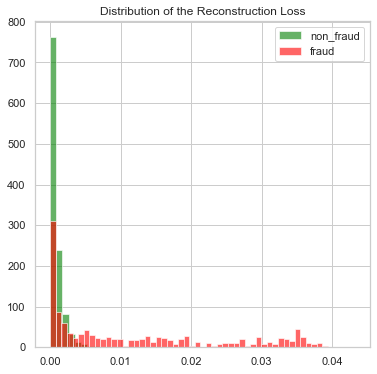

In [20]:
non_fraud = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(non_fraud, bins=50, density=True, label="non_fraud", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

비록 몇 거래들은 qutoencoder를 속이는것 처럼 보이지만. 사기거래들은 명확히 정상거래와 그들의 데이터를 구분해낸다. 

<a id="5.2"></a>
## 5-2. Setting a threshold for classification

- 우리는 false positives를 제한하기 위한 임계값을 정해야합니다. 그리고 사기거래들을 잡아내야 합니다. 
- Percentiles : 데이터의 상위 x%만을 가지고 임계값을 정해서 사기거래를 고려할 수 있음
- MAD : 이상치를 정의하기 위해서 Median Absolute Deviation방법을 사용하는 수정된 Z-score을 사용할 수 있습니다. 이 방법이 percentile보다 더 견고하고 확장 가능

In [21]:
def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)

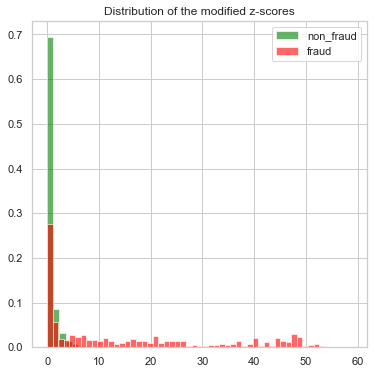

In [22]:
non_fraud = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(non_fraud, bins=50, density=True, label="non_fraud", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

In [23]:
# 각각의 reconstruction에 대해서 THRESHOLD보다 더 크면 이상치로 분류한다.

THRESHOLD = 3
outliers = z_scores > THRESHOLD
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 5,079 outliers in a total of 84,807 transactions [5.99%].


- THRESHOLD사 3일때, 전체 84,807거래 중에 약 7%를 사기거래로 구분했다. 
- 정답을 알고 있기 때문에 MAD방법으로 이상치를 분류한것의 성능을 확인해보자

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, outliers)

print(classification_report(y_test, outliers))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     84315
           1       0.06      0.67      0.10       492

    accuracy                           0.93     84807
   macro avg       0.53      0.80      0.53     84807
weighted avg       0.99      0.93      0.96     84807



In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, outliers)

print(classification_report(y_test, outliers))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     84315
           1       0.06      0.63      0.11       492

    accuracy                           0.94     84807
   macro avg       0.53      0.79      0.54     84807
weighted avg       0.99      0.94      0.96     84807



---

<br><br>

<a id="6"></a>
# 6. Fraud detection for model2

<a id="6.1"></a>
## 6-1. Obtain the Latent Representations

- 다음은 모델2에 대해서 적용한다. 
- 모델 학습은 끝났다. 우리는 모델에 의해 input의 잠재벡터를 얻고싶다. 이것은 학습된 모델의 가중치를 통해 얻을 수 있다.
- 우리는 sequence layer를 갖는 또다른 network를 만들것이다. 그리고 잠재벡터가 존재하는 3번째 층에 학습된 가중치를 더해줄 것이다. 

In [16]:
# trained model의 layer(first), second, third층만 가지고 새로운 network생성  

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [17]:
# 정상거래에 대한 latent vector
norm_hid_rep = hidden_representation.predict(x_norm[:3000])

# 사기거래에 대한 latent vector
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [20]:
# autoencoder의 세번째 층의 크기를 50으로 해주었기 때문에 
# Latent vetor의 크기도 50차원임을 알 수 있다. 
len(norm_hid_rep[0])

50

<a id="6.2"></a>
## 6-2. Visualize the latent representations : Fraud Vs Non Fraud

이제는 위에서 얻은 잠재벡터를 사용해서 새로운 데이터셋을 만들어볼것이다. 정상거래와 사기거래를 시각화해보자.

3000
492
3492


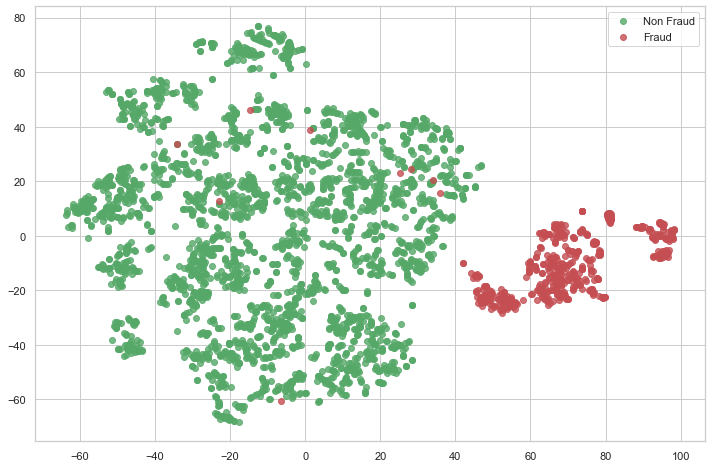

In [26]:
print(len(norm_hid_rep))
print(len(fraud_hid_rep))

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
print(len(rep_x))

y_n = np.zeros(norm_hid_rep.shape[0]) # 정상거래 행 수만큼 label붙여주기
y_f = np.ones(fraud_hid_rep.shape[0]) # 사기거래 행 수만큼 label붙여주기
rep_y = np.append(y_n, y_f)

tsne_plot(rep_x, rep_y, "latent_representation.png")

- 완벽한 그래프이다! 우리는 정상거래와 사기거래가 꽤 잘 구분되고 선형적으로 분리되어지는것을 볼 수 있다. 지금 우리는 이들을 구분해내기 위해 어떠한 복잡한 모델을 필요로 하지 않는다. 심지어 훨씬 더 단순한 모델이 예측을 위해 사용되어졌다. 

<a id="6.3"></a>
## 6-3. Simple Linear Classifier

- 위에서 새롭게 만든 데이터셋에서 선형회귀를 사용해서 훈련을 시켜보자

In [27]:
# 위에서 만든 잠재벡터를 사용
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       1.00      0.90      0.95       131

    accuracy                           0.99       873
   macro avg       0.99      0.95      0.97       873
weighted avg       0.99      0.99      0.98       873


Accuracy Score:  0.9851088201603666
